In [1]:
import pandas as pd
import numpy as np

import wrangle as w

import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy import stats

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = w.banking()

In [3]:
train, validate, test = w.data_split(df, 'y_encoded')
train.shape, validate.shape, test.shape

((34812, 59), (7460, 59), (7460, 59))

In [5]:
# Establish my baseline and print it
# Accuracy baseline would be majority class population 
# Precision baseline would be positive class population 
baseline_accuracy = (train['y_encoded'] == 0).mean()
baseline_precision = (train.y_encoded).mean()
print(f'The baseline accuracy is {baseline_accuracy * 100:.2f}%')
print(f'The baseline precision is {baseline_precision * 100:.2f}%')

The baseline accuracy is 88.32%
The baseline precision is 11.68%


In [6]:
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
23223,48,entrepreneur,married,primary,no,3705,yes,no,unknown,15,...,0,0,1,0,0,0,0,0,0,1
11697,57,admin.,married,secondary,no,2137,no,no,telephone,8,...,0,0,0,0,0,0,0,0,0,1
31069,39,blue-collar,married,primary,no,1046,no,no,unknown,19,...,1,0,0,0,0,0,0,0,0,1
33934,36,student,single,secondary,no,904,no,no,unknown,20,...,1,0,0,0,0,0,0,0,0,1
40218,34,management,married,tertiary,no,8,no,no,cellular,25,...,0,0,0,0,0,0,0,0,0,1


In [7]:
X_train= train.drop(columns = ['job','marital','education','default', 'housing', 'loan','contact','month','duration','poutcome','y','y_encoded'])
y_train = train.y_encoded


X_validate = validate.drop(columns = ['job','marital','education','default', 'housing', 'loan','contact','month','duration','poutcome','y','y_encoded'])
y_validate = validate.y_encoded

X_test = test.drop(columns = ['job','marital','education','default', 'housing', 'loan','contact','month','duration','poutcome','y','y_encoded'])
y_test = test.y_encoded



In [8]:
def model_split(train, validate, test):

    X_train= train.drop(columns = ['job','marital','education','default', 'housing', 'loan','contact','month','duration','poutcome','y','y_encoded'])
    y_train = train.y_encoded
    
    
    X_validate = validate.drop(columns = ['job','marital','education','default', 'housing', 'loan','contact','month','duration','poutcome','y','y_encoded'])
    y_validate = validate.y_encoded
    
    X_test = test.drop(columns = ['job','marital','education','default', 'housing', 'loan','contact','month','duration','poutcome','y','y_encoded'])
    y_test = test.y_encoded



    return X_train, y_train, X_validate, y_validate, X_test, y_test

## Decision Tree

In [9]:
# made a for loop to make the model, fit the model, 
# run the model(using in/out of sample accuracy) and evaluate the model to run through different max depths

metrics = []

for i in range(2,11):
    
    clf = DecisionTreeClassifier(max_depth = i, random_state = 42)
    
    clf.fit(X_train, y_train)

    # Predictions
    
    y_train_preds = clf.predict(X_train)
    y_validate_preds = clf.predict(X_validate)       
    y_validate_proba = clf.predict_proba(X_validate)[:,1]

    # Accuracy
    train_accuracy = accuracy_score(y_train, y_train_preds)
    validate_accuracy = accuracy_score(y_validate, y_validate_preds)

    # precision, recall, f1, auc
    precision = precision_score(y_validate, y_validate_preds)
    recall = recall_score(y_validate, y_validate_preds)
    f1 = f1_score(y_validate, y_validate_preds)
    auc = roc_auc_score(y_validate, y_validate_proba)

    output = {
        'max_depth': i,
        'train_accuracy': train_accuracy,
        'validate_accuracy': validate_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': auc
    }

    metrics.append(output)

df_dt = pd.DataFrame(metrics)
df_dt['difference'] = df_dt.train_accuracy - df_dt.validate_accuracy

df_dt.sort_values('precision', ascending=False).reset_index(drop= 'index')

,max_depth,train_accuracy,validate_accuracy,precision,recall,f1_score,roc_auc,difference
0,3,0.892910,0.891287,0.676471,0.132032,0.220941,0.615928,0.001624
1,8,0.901672,0.894236,0.654135,0.199770,0.306069,0.713394,0.007436
2,4,0.893973,0.891957,0.649770,0.161883,0.259191,0.629617,0.002016
3,7,0.899201,0.894906,0.646465,0.220436,0.328767,0.718104,0.004295
4,5,0.896243,0.893432,0.643939,0.195178,0.299559,0.697666,0.002811
5,6,0.897507,0.892895,0.630435,0.199770,0.303400,0.711112,0.004611
6,2,0.892709,0.890885,0.622318,0.166475,0.262681,0.604526,0.001825
7,9,0.904688,0.892895,0.616883,0.218140,0.322307,0.711336,0.011793
8,10,0.907877,0.891421,0.616858,0.184845,0.284452,0.693693,0.016456


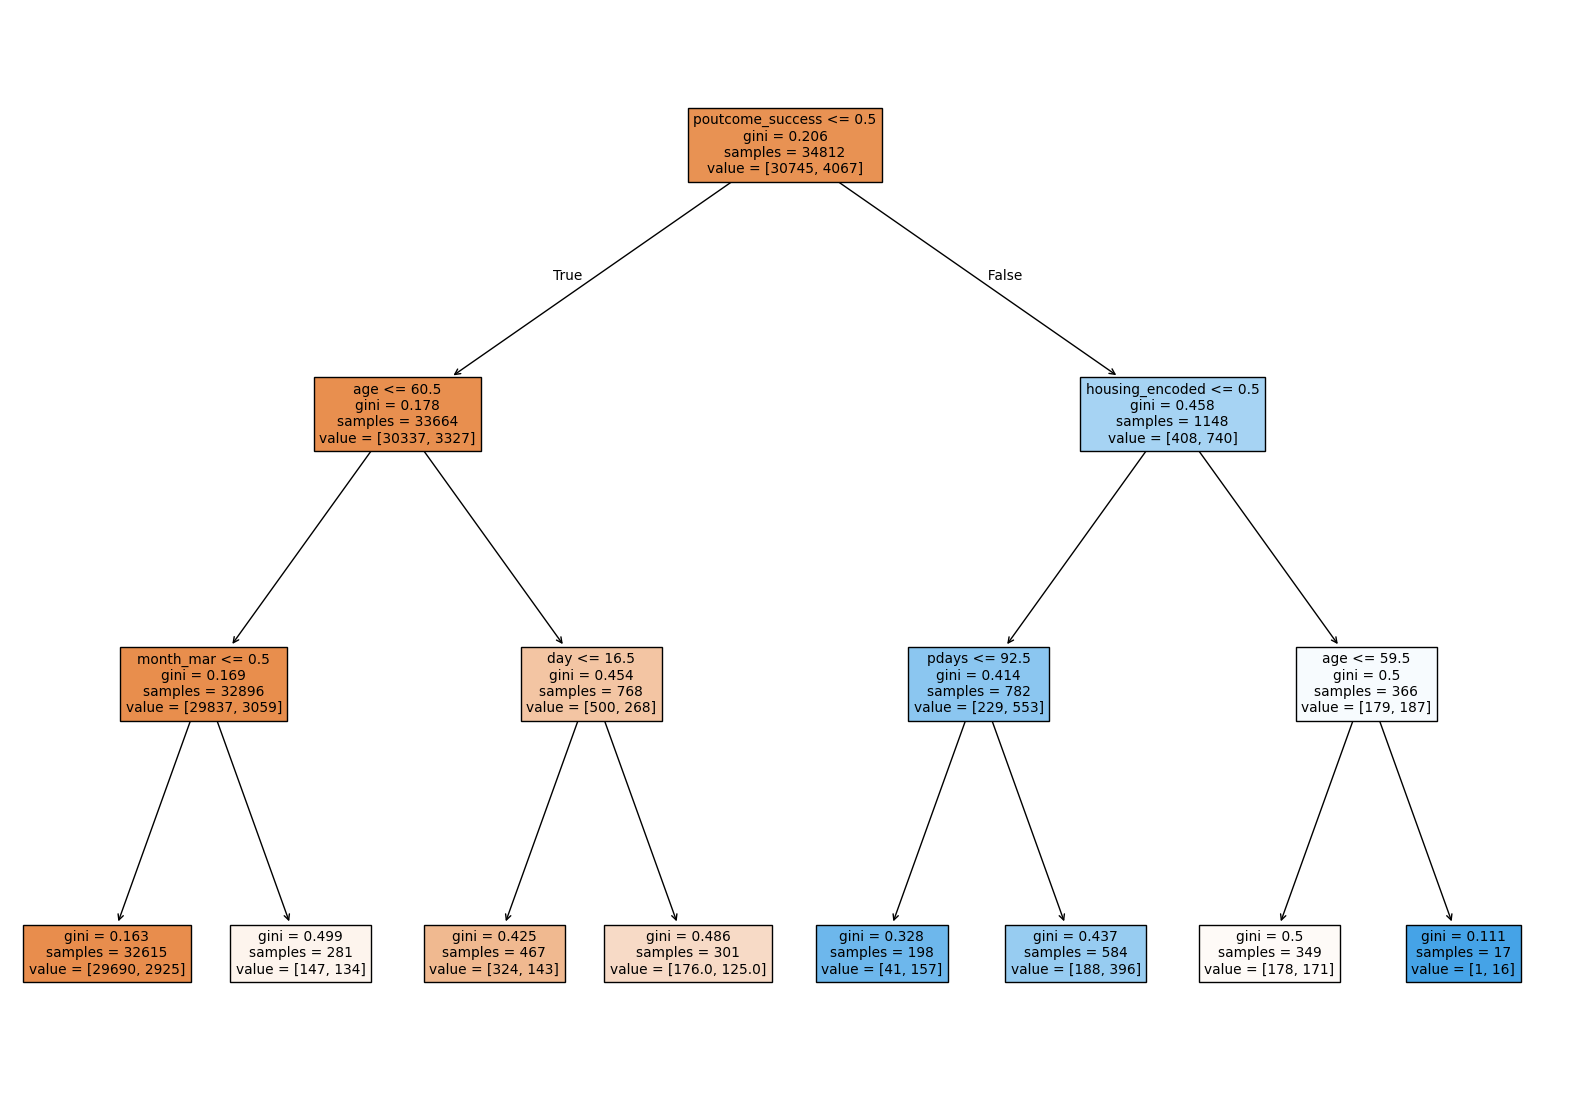

In [10]:
clf = DecisionTreeClassifier(max_depth = 3, random_state = 42)
clf = clf.fit(X_train,y_train)
plt.figure(figsize=(20, 14))
plot_tree(clf, feature_names = X_train.columns, filled = True )
plt.show()

#### Takeaway

- Our decision tree model with a depth of 3 has the smallest/best difference between our in sample and out of sample data subset. Giving us with an accuracy of 89.29% in sample and 89.12% out of sample.

- When looking at precision we also notice the same model work best at 67.65%

## Random Forest Models

In [11]:
rf = RandomForestClassifier(n_estimators= 2, random_state= 42)
rf =rf.fit(X_train,y_train)
in_sample_accuracy = rf.score(X_train,y_train)
out_of_sample_accuracy = rf.score(X_validate, y_validate)

In [12]:
in_sample_accuracy, out_of_sample_accuracy

(0.9510513615994485, 0.8873994638069705)

In [13]:
metrics = []
max_depth = 11

for i in range(1, max_depth):
    depth = max_depth - i
    n_samples = i
    rf = RandomForestClassifier(max_depth = depth, min_samples_leaf = n_samples,
                                random_state = 42, n_estimators = 200)

    rf.fit(X_train, y_train)


    # Predictions
    y_train_pred = rf.predict(X_train)
    y_validate_pred = rf.predict(X_validate)
    y_validate_prob = rf.predict_proba(X_validate)[:, 1]

    # Accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    validate_accuracy = accuracy_score(y_validate, y_validate_pred)

    # precision, recall, f1, auc
    precision = precision_score(y_validate, y_validate_pred)
    recall = recall_score(y_validate, y_validate_pred)
    f1 = f1_score(y_validate, y_validate_pred)
    auc = roc_auc_score(y_validate, y_validate_prob)

    output = {
        'max_depth': depth,
        'min_samples_leaf': n_samples,
        'train_accuracy': train_accuracy,
        'validate_accuracy': validate_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': auc
    }

    metrics.append(output)

df_rf = pd.DataFrame(metrics)
df_rf['difference'] = df_rf.train_accuracy - df_rf.validate_accuracy

df_rf.sort_values('precision', ascending=False).reset_index(drop= 'index')

,max_depth,min_samples_leaf,train_accuracy,validate_accuracy,precision,recall,f1_score,roc_auc,difference
0,9,2,0.897191,0.892761,0.691892,0.146958,0.242424,0.781667,0.004429
1,6,5,0.894002,0.891421,0.689441,0.127440,0.215116,0.765117,0.002581
2,10,1,0.900379,0.893164,0.686869,0.156142,0.254443,0.788372,0.007216
3,8,3,0.896013,0.892359,0.686813,0.143513,0.237417,0.778251,0.003654
4,7,4,0.895094,0.892091,0.681319,0.142365,0.235518,0.773109,0.003002
5,5,6,0.891733,0.887936,0.676768,0.076923,0.138144,0.757878,0.003797
6,4,7,0.885155,0.883780,0.642857,0.010333,0.020339,0.747690,0.001374
7,3,8,0.883172,0.883244,0.000000,0.000000,0.000000,0.737260,-0.000071
8,2,9,0.883172,0.883244,0.000000,0.000000,0.000000,0.728899,-0.000071
9,1,10,0.883172,0.883244,0.000000,0.000000,0.000000,0.719737,-0.000071


#### Takeaways

- Model with max depth of 4 has the best in sample and out of sample accuracy
- When looking for precision (Not wasting calls) we see that model indexed 1 or with max_depth of 9 with min_sample_leaf of 2 has the best precision score

## KNN

In [14]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)

y_train_preds = knn.predict(X_train)
y_validate_preds = knn.predict(X_validate)
y_validate_proba = knn.predict_proba(X_validate)[:,1]

train_accuracy = accuracy_score(y_train,y_train_preds)
validate_accuracy = accuracy_score(y_validate,y_validate_preds)

precision = precision_score(y_validate, y_validate_preds)
recall = recall_score(y_validate, y_validate_preds)
f1 = f1_score(y_validate, y_validate_preds)
roc_auc = roc_auc_score(y_validate, y_validate_proba)

In [15]:
output = { 'train_accuracy': train_accuracy,
           'validate_accuracy': validate_accuracy,
           'precision': precision,
           'recall': recall,
           'f1_score': f1,
           'roc_auc': roc_auc}
output
    

{'train_accuracy': 0.8974491554636332,
 'validate_accuracy': 0.8746648793565683,
 'precision': 0.375,
 'recall': 0.11021814006888633,
 'f1_score': 0.17036379769299023,
 'roc_auc': np.float64(0.6376701314283852)}

In [16]:
metrics = []

for i in range(1,21):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    
    knn.fit(X_train,y_train)
    
    y_train_preds = knn.predict(X_train)
    y_validate_preds = knn.predict(X_validate)
    y_validate_proba = knn.predict_proba(X_validate)[:,1]
    
    train_accuracy = accuracy_score(y_train,y_train_preds)
    validate_accuracy = accuracy_score(y_validate,y_validate_preds)
    
    precision = precision_score(y_validate, y_validate_preds)
    recall = recall_score(y_validate, y_validate_preds)
    f1 = f1_score(y_validate, y_validate_preds)
    roc_auc = roc_auc_score(y_validate, y_validate_proba)

    output = { 
           'neighbors': i, 
           'train_accuracy': train_accuracy,
           'validate_accuracy': validate_accuracy,
           'precision': precision,
           'recall': recall,
           'f1_score': f1,
           'roc_auc': roc_auc
            }
    
    metrics.append(output)

df_knn = pd.DataFrame(metrics)
df_knn['difference'] = df_knn.train_accuracy - df_knn.validate_accuracy 
df_knn.sort_values('precision', ascending= False).reset_index(drop= 'index')

,neighbors,train_accuracy,validate_accuracy,precision,recall,f1_score,roc_auc,difference
0,6,0.892853,0.882172,0.466667,0.064294,0.113017,0.643146,0.010681
1,2,0.919740,0.880161,0.440415,0.097589,0.159774,0.626492,0.039579
2,20,0.885068,0.882172,0.431034,0.028703,0.053821,0.652835,0.002897
3,8,0.889435,0.881099,0.424528,0.051665,0.092119,0.643050,0.008335
4,9,0.890153,0.880027,0.416667,0.068886,0.118227,0.644328,0.010126
5,11,0.888257,0.879893,0.406015,0.061998,0.107570,0.646071,0.008364
6,4,0.898455,0.879357,0.402685,0.068886,0.117647,0.631989,0.019098
7,18,0.885815,0.881501,0.400000,0.029851,0.055556,0.656198,0.004314
8,10,0.888515,0.880697,0.397849,0.042480,0.076763,0.646688,0.007818
9,7,0.892968,0.878016,0.395722,0.084960,0.139887,0.643351,0.014952


## Logistic Regression 

In [17]:
metrics = []
c_reg = [0.01, 0.1, 1, 10]

for i in c_reg:

    log = LogisticRegression(max_iter = 2000, class_weight = 'balanced',C = i, random_state = 1722)

    log.fit(X_train, y_train)

    
    y_train_preds = log.predict(X_train)
    y_validate_preds = log.predict(X_validate)
    y_validate_proba = log.predict_proba(X_validate)[:,1]
    
    train_accuracy = accuracy_score(y_train,y_train_preds)
    validate_accuracy = accuracy_score(y_validate,y_validate_preds)
    
    precision = precision_score(y_validate, y_validate_preds)
    recall = recall_score(y_validate, y_validate_preds)
    f1 = f1_score(y_validate, y_validate_preds)
    roc_auc = roc_auc_score(y_validate, y_validate_proba)

    
    metrics.append({
        "regularization": i,
        "train_accuracy": train_accuracy,
        "validate_accuracy": validate_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    })

    

df_log = pd.DataFrame(metrics)
df_log['difference'] = df_log.train_accuracy - df_log.validate_accuracy 
df_log.sort_values('precision', ascending= False).reset_index(drop= 'index')

,regularization,train_accuracy,validate_accuracy,precision,recall,f1_score,roc_auc,difference
0,0.10,0.759250,0.759249,0.265109,0.599311,0.367606,0.750484,3.542583e-07
1,10.00,0.749081,0.752949,0.261062,0.609644,0.365577,0.751687,-3.868285e-03
2,1.00,0.749052,0.751475,0.258714,0.605052,0.362448,0.750165,-2.422480e-03
3,0.01,0.736528,0.736997,0.248965,0.621125,0.355453,0.751169,-4.696849e-04


In [18]:
models = {'decision_tree':df_dt,'random_forest':df_rf,'knn':df_knn,'logistic_regression':df_log}
best_model = []


for name, model in models.items():
    top_model = model.loc[0,'train_accuracy':'difference']

    row_dict = top_model.to_dict()
    
    row_dict['model'] = name
    
    best_model.append(row_dict)

best_performing_models = pd.DataFrame(best_model)
model_col = best_performing_models.pop('model')
best_performing_models.insert(0, 'model', model_col)

best_performing_models = best_performing_models.sort_values('precision', ascending = False).reset_index(drop = 'index')


In [19]:
best_performing_models

,model,train_accuracy,validate_accuracy,precision,recall,f1_score,roc_auc,difference
0,random_forest,0.900379,0.893164,0.686869,0.156142,0.254443,0.788372,0.007216
1,decision_tree,0.892709,0.890885,0.622318,0.166475,0.262681,0.604526,0.001825
2,knn,1.000000,0.849196,0.342822,0.318025,0.329958,0.618718,0.150804
3,logistic_regression,0.736528,0.736997,0.248965,0.621125,0.355453,0.751169,-0.000470


In [20]:
def model_scores(X_train, y_train, X_val, y_val):
    '''
    Score multiple models on train and validate datasets.
    Print classification reports to look at the best model to test on.
    Returns each different trained model.
    models = decision_tree_model, random_forest_model, knn_model, logistic_regression_model
    '''
    
    decision_tree_model = DecisionTreeClassifier(max_depth = 3, random_state = 42)
    
    random_forest_model = RandomForestClassifier(max_depth = 9, min_samples_leaf = 2, n_estimators=200, random_state = 42)
    
    knn_model = KNeighborsClassifier(n_neighbors = 6)
    
    logistic_regression_model = LogisticRegression(max_iter= 2000, C=.10,class_weight='balanced', random_state = 1722)
    
    models = [decision_tree_model, random_forest_model, knn_model, logistic_regression_model]
    
# within this for loop I fitted each model, 
# got my actual values and my predicted values for each model
# printed my train and validate score and classification report

    for model in models:
        model.fit(X_train, y_train)
        actual_train = y_train
        predicted_train = model.predict(X_train)
        actual_val = y_val
        predicted_val = model.predict(X_val)
        
        print(model)
        print('\n')
        print('Train Score: ')
        print(classification_report(actual_train, predicted_train))
        print('Validate Score: ')
        print(classification_report(actual_val, predicted_val))
        print('--------------------------------------------------------------')
        print('\n')

    return decision_tree_model, random_forest_model, knn_model, logistic_regression_model

In [21]:
decision_tree_model, random_forest_model, knn_model, logistic_regression_model = model_scores(X_train, y_train, X_validate, y_validate)
decision_tree_model, random_forest_model, knn_model, logistic_regression_model

DecisionTreeClassifier(max_depth=3, random_state=42)


Train Score: 
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     30745
           1       0.71      0.14      0.23      4067

    accuracy                           0.89     34812
   macro avg       0.80      0.57      0.59     34812
weighted avg       0.88      0.89      0.86     34812

Validate Score: 
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      6589
           1       0.68      0.13      0.22       871

    accuracy                           0.89      7460
   macro avg       0.79      0.56      0.58      7460
weighted avg       0.87      0.89      0.86      7460

--------------------------------------------------------------


RandomForestClassifier(max_depth=9, min_samples_leaf=2, n_estimators=200,
                       random_state=42)


Train Score: 
              precision    recall  f1-score   support

          

(DecisionTreeClassifier(max_depth=3, random_state=42),
 RandomForestClassifier(max_depth=9, min_samples_leaf=2, n_estimators=200,
                        random_state=42),
 KNeighborsClassifier(n_neighbors=6),
 LogisticRegression(C=0.1, class_weight='balanced', max_iter=2000,
                    random_state=1722))

In [22]:
# test_model = decision_tree_model.fit(X_test,y_test) don't fit within the test dataset
test_y_pred = random_forest_model.predict(X_test)

# classification report
print(classification_report(y_test, test_y_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      6588
           1       0.73      0.18      0.28       872

    accuracy                           0.90      7460
   macro avg       0.82      0.58      0.61      7460
weighted avg       0.88      0.90      0.87      7460



In [26]:
def test_model(X_test, y_test):
    
    test_y_pred = random_forest_model.predict(X_test)
    
    test_precision = precision_score(y_test,test_y_pred)
    
    best_performing_models.loc[0, 'test_precision'] = test_precision
    
    return best_performing_models.loc[0]

In [23]:
test_precision = precision_score(y_test,test_y_pred)

In [24]:
best_performing_models.loc[0, 'test_precision'] = test_precision

In [25]:
#Random Forest 
best_performing_models.loc[0]

model                random_forest
train_accuracy            0.900379
validate_accuracy         0.893164
precision                 0.686869
recall                    0.156142
f1_score                  0.254443
roc_auc                   0.788372
difference                0.007216
test_precision            0.733333
Name: 0, dtype: object

In [37]:
#getting probabilities of our clients that would make term deposits within out test subset
y_probs = random_forest_model.predict_proba(X_test)[:, 1]

In [39]:
#make a copy of X_test
#make a new column as the probabilities for each client
#make a new column as an int of 0 or 1 based on prob. of .5 (50%) or greater
#filter results to have only predicted clients to make term deposits and sort by the highest prob. to lowest prob

results = X_test.copy()
results["probability_subscribe"] = y_probs
results["predicted"] = (y_probs >= 0.5).astype(int)

call_list = results[results["predicted"] == 1].sort_values("probability_subscribe", ascending=False)
call_list

,age,balance,day,campaign,pdays,previous,default_encoded,housing_encoded,loan_encoded,job_admin.,...,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,probability_subscribe,predicted
47318,36,1291,30,1,86,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0.734826,1
47518,25,2354,30,1,84,7,0,0,0,0,...,0,0,0,0,0,0,1,0,0.728441,1
47408,56,616,30,1,83,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0.717533,1
45363,27,390,28,1,82,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0.712692,1
40968,78,1780,25,2,185,7,0,1,0,0,...,0,0,1,0,0,0,1,0,0.708707,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20146,55,538,13,1,67,2,0,1,0,0,...,0,0,1,0,0,0,1,0,0.511402,1
49040,55,1504,31,3,101,2,0,1,0,0,...,0,0,0,0,0,0,1,0,0.505605,1
6522,41,1646,5,1,90,7,0,1,0,0,...,1,0,0,0,0,0,1,0,0.505107,1
32275,74,4079,19,3,-1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0.504048,1


In [40]:
# convert dataframe to a csv
call_list.to_csv("high_precision_call_list.csv", index=True)